In [1]:
# Clear Jupyter notebook output and clear all variables
from IPython.display import clear_output
clear_output(wait=True)

# Remove all user-defined variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
# Set path to the parent directory
import sys
import os
file = "/home/ashwin/GIT/PulsarAnalyticsKit/"
sys.path.append(file)

# Import necessary modules
from core.pulsar_analysis import pulsar_analysis
from core.generic_plotting import *


In [2]:
class pulsar_analysis(pulsar_analysis):
    def template(self):
        print("Template for pulsar analysis")

    def load_data(self):
        
        if self.data_type == 'ascii':
            #also skip first few lines
            self.raw_data = np.loadtxt(self.file_path, skiprows=self.skip_rows)
            self.n_channels = self.raw_data.shape[1]

        elif self.data_type == 'binary_int32':
            self.raw_data = np.fromfile(self.file_path, dtype=np.int32).reshape(-1, self.n_channels)
        
        elif self.data_type == 'binary_int16':
            self.raw_data = np.fromfile(self.file_path, dtype=np.int16).reshape(-1, self.n_channels)

        elif self.data_type == 'swan':
            dt = np.dtype([
                ('header', 'S8'), ('Source', 'S10'),
                ('Attenuator_1', '>u1'), ('Attenuator_2', '>u1'),
                ('Attenuator_3', '>u1'), ('Attenuator_4', '>u1'),
                ('LO', '>u2'), ('FPGA', '>u2'),
                ('GPS', '>u2'), ('Packet', '>u4'),
                ('data', '>i1', 1024)
            ])
            self.memmap_file = np.memmap(self.file_path, dtype=dt, mode='r')
            self.data_blocks = self.memmap_file['data']

            reshaped = self.data_blocks.reshape(-1)
            ch0 = (reshaped[0::2].astype(np.int32))
            ch1 = (reshaped[1::2].astype(np.int32))
            self.raw_data = np.stack([ch0, ch1], axis=1)
            self.n_channels = 2
        else:
            raise ValueError("Unsupported data type. Use 'ascii', 'binary_int32' or 'swan'.")        
        print(f"Given Data is of ndim : {self.raw_data.ndim} . shape : {self.raw_data.shape[1]}")
        self.n_channels = self.raw_data.shape[1]

In [3]:
crab_data = "/home/ashwin/GIT/PulsarAnalyticsKit/Data4Analysis/Crab/ch05_CRAB_20090725_095307_000.txt"
skip_rows = 1
bandwidth_MHZ = 46 # CH5
center_freq_MHZ = 425 # CH5

pulsar = pulsar_analysis(crab_data, channel_names=["N", "S"], data_type='ascii',block_size=512, avg_blocks=60, sample_rate=33e6,bandwidth_MHZ=bandwidth_MHZ, center_freq_MHZ=center_freq_MHZ, skip_rows=skip_rows)


Given Data is of ndim : 2 . shape : 2
file_path: /home/ashwin/GIT/PulsarAnalyticsKit/Data4Analysis/Crab/ch05_CRAB_20090725_095307_000.txt
data_type: ascii
n_channels: 2
raw_data shape :  (33000448, 2)
channel_names: ['N', 'S']
block_size: 512
avg_blocks: 60
sample_rate: 33000000.0
intensity_matrix_ch_s shape :  (2,)
dedispersed_ch_s shape :  (2,)
dedispersed_choped_ch_s: [None None]
folded_ch_s: [None None]
center_freq_MHZ: 425
bandwidth_MHZ: 46
skip_rows: 1
stokes_parameters shape :  (4,)
L: None
P_frac: None
PA: None


Stokes parameters calculated successfully


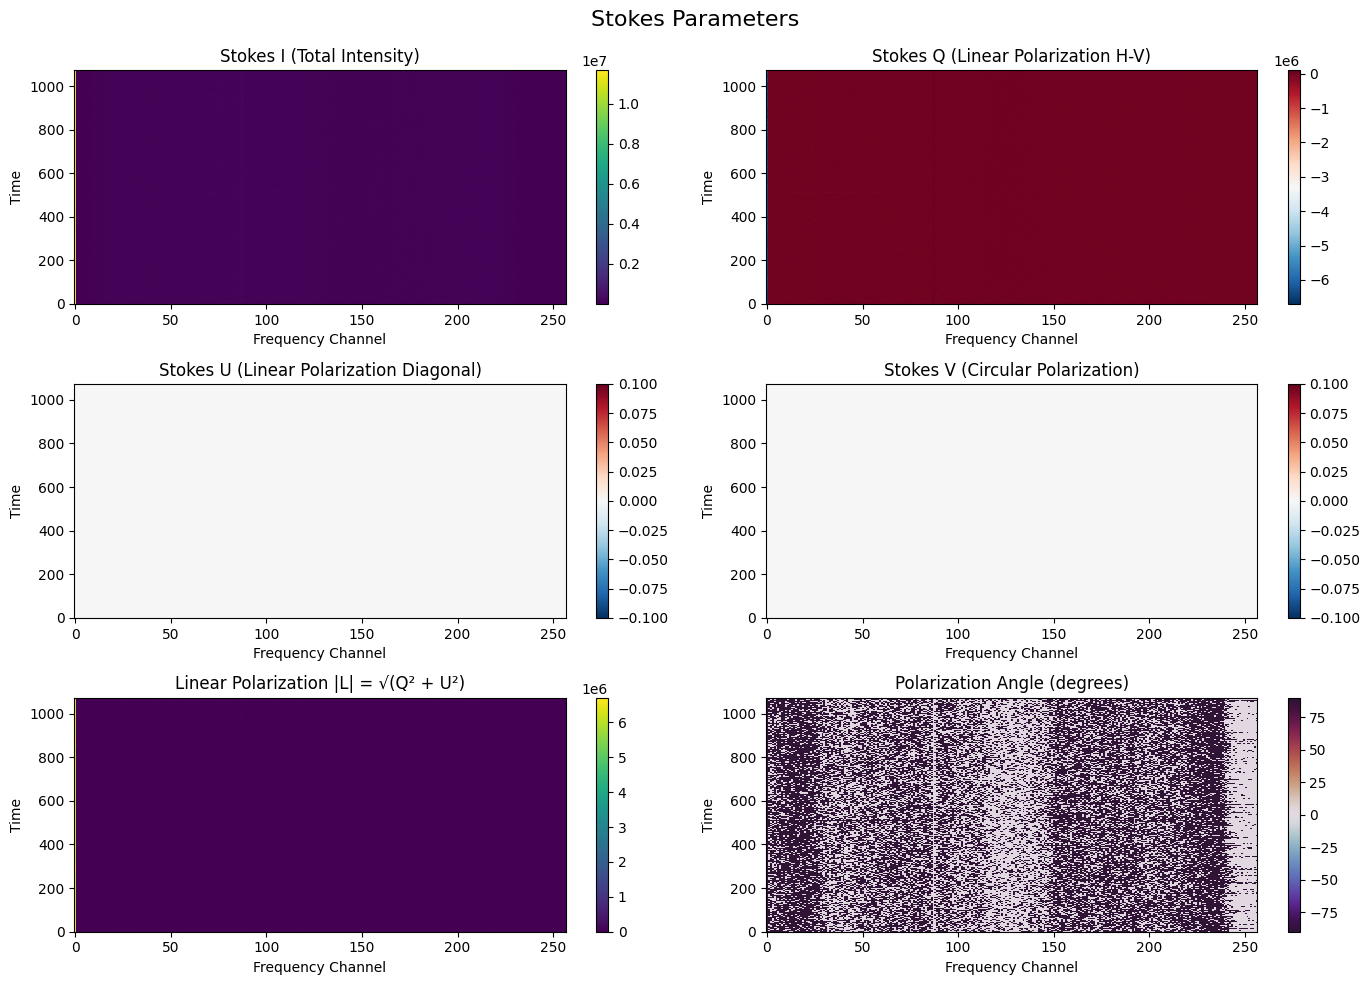

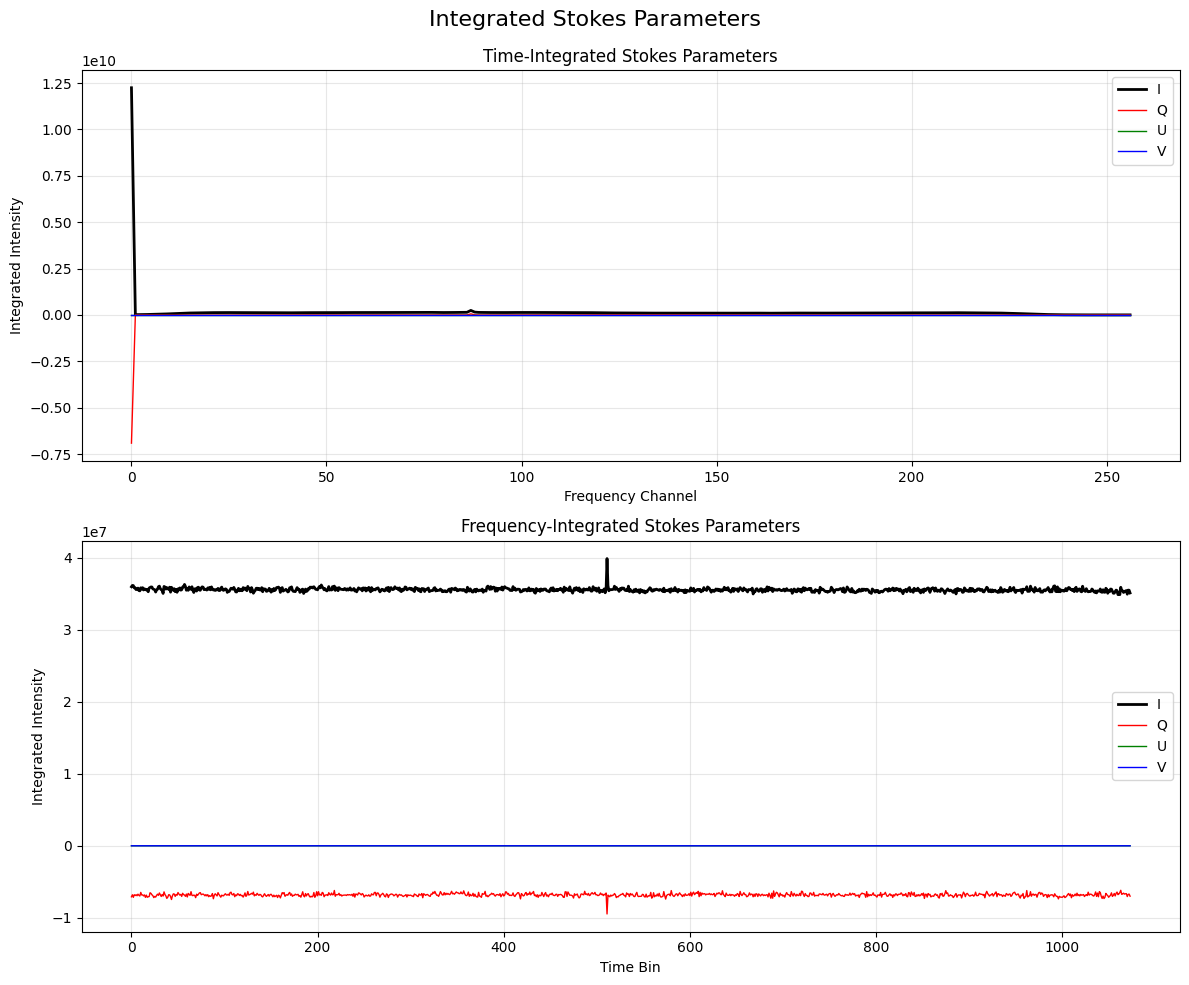

In [4]:
pulsar.compute_intensity_matrix()
# Calculate Stokes parameters
pulsar.calculate_stokes_parameters()

# Plot Stokes parameters
pulsar.plot_stokes_parameters()

# Plot integrated Stokes parameters
pulsar.plot_integrated_stokes()

In [5]:
# crab_data = "/home/ashwin/GIT/PulsarAnalyticsKit/Data4Analysis/Crab/ch05_CRAB_20090725_095307_000_cut.mbr"
# skip_rows = 1
# pulsar = pulsar_analysis(crab_data, channel_names=["N", "S"], data_type='swan',block_size=512, avg_blocks=60, sample_rate=33e6,skip_rows=skip_rows)


In [6]:
percentofData = 90 # Percentage of data to analyze
n = int(pulsar.raw_data.shape[0] * percentofData / 100)

ch0 = pulsar.raw_data[int(n/2):n , 0]
ch1 = pulsar.raw_data[int(n/2):n, 1]
fs = pulsar.sample_rate

# compare_channels(ch0,ch1, fs, label="Comparision of N and S channels",)

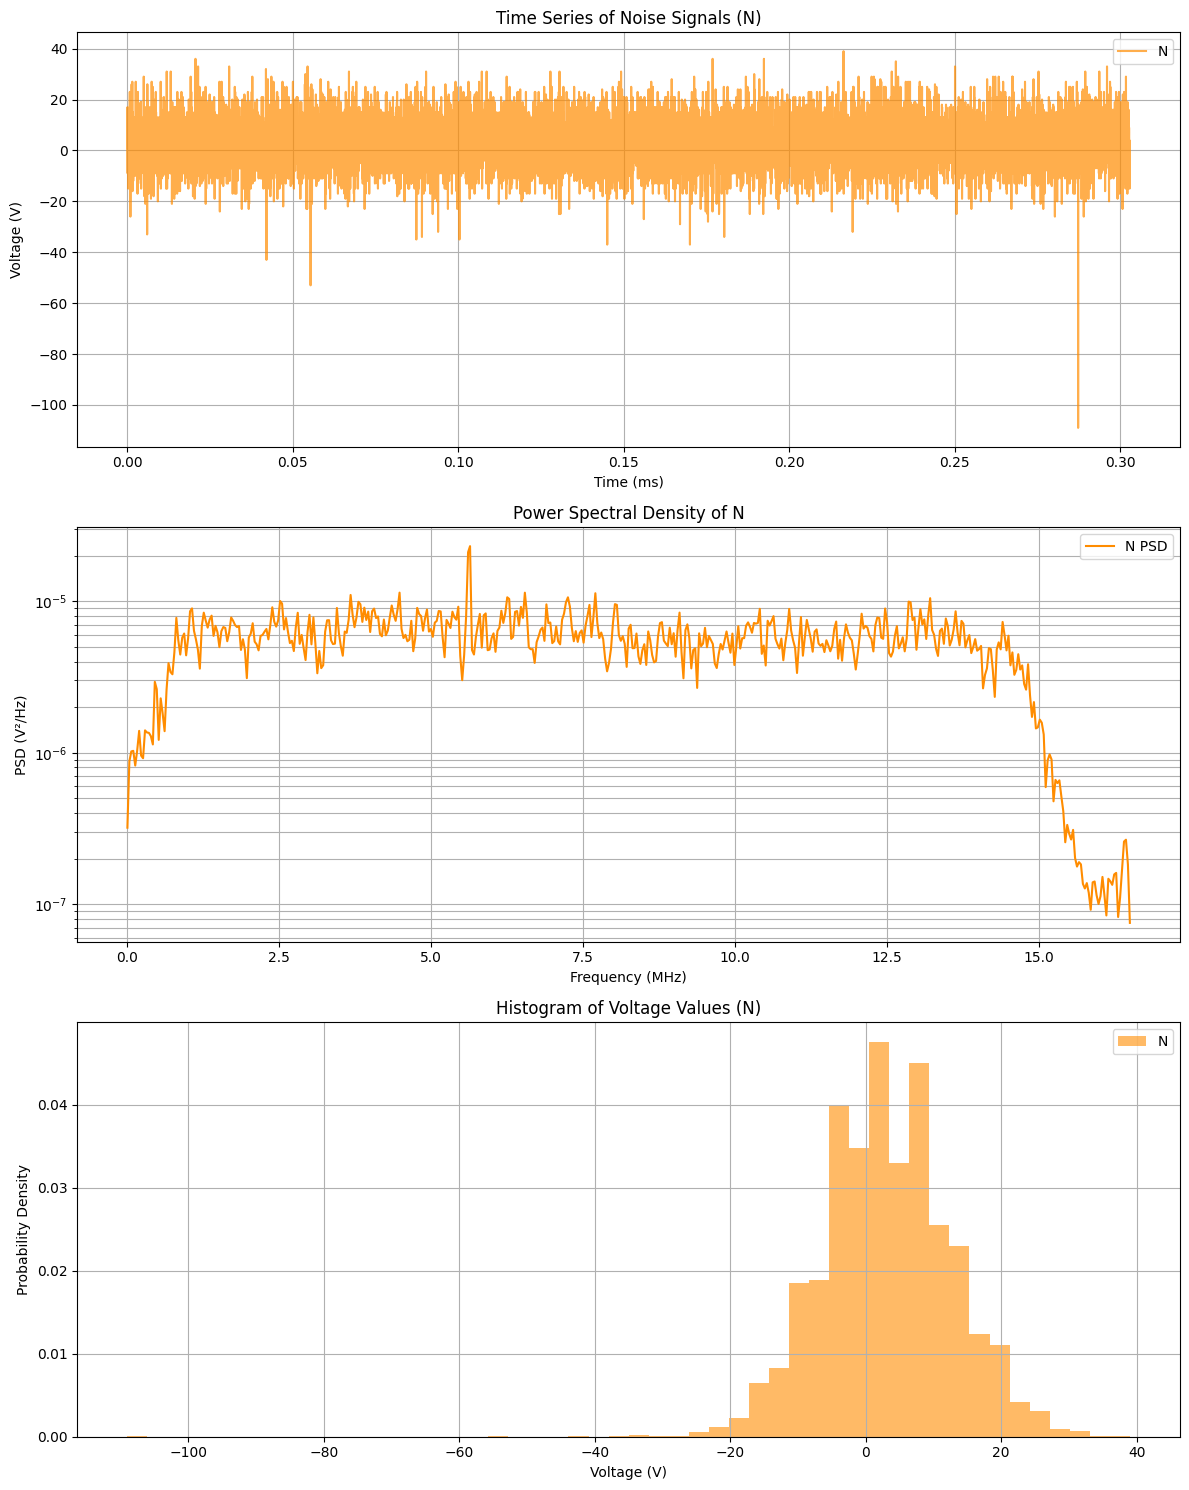

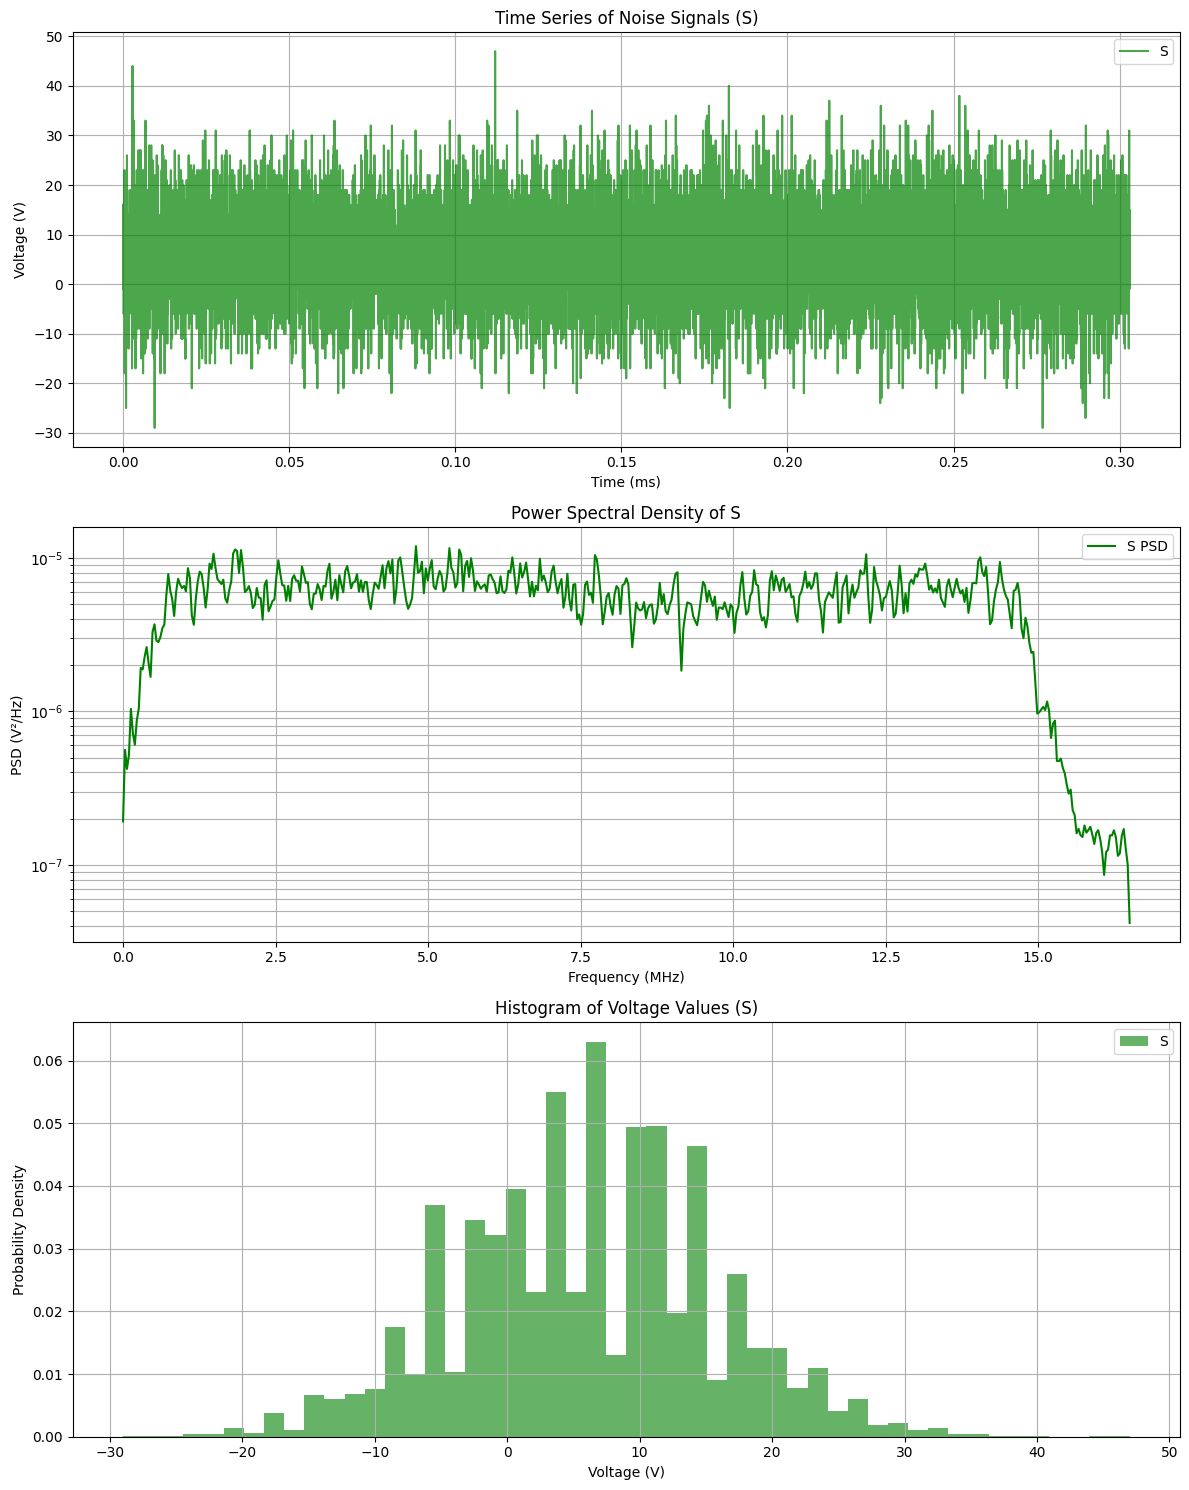

In [7]:
Plot_characterstics(pulsar,channel=0)
Plot_characterstics(pulsar,channel=1)

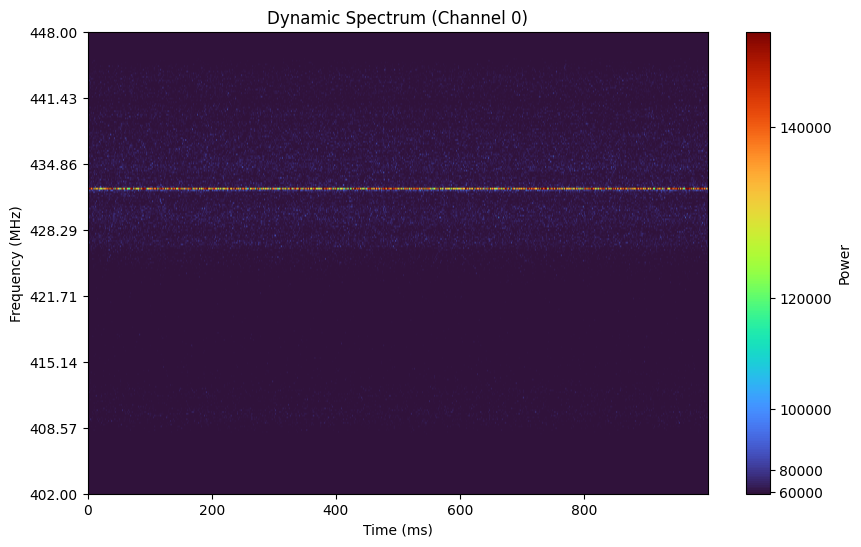

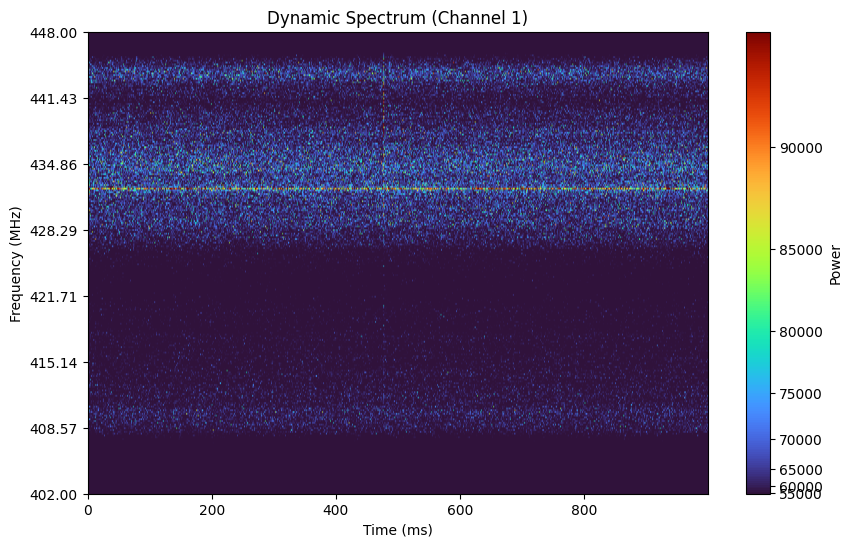

In [8]:
pulsar.compute_intensity_matrix()
plot_intensity_matrix(pulsar,channel = 0)
plot_intensity_matrix(pulsar,channel = 1)

Flagging 1 channels as RFI heavy
Flagging 1 channels as RFI heavy


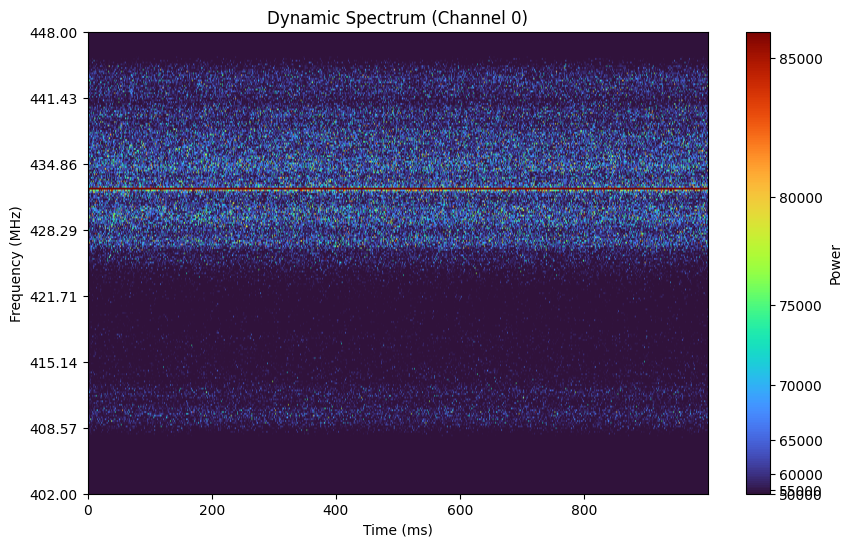

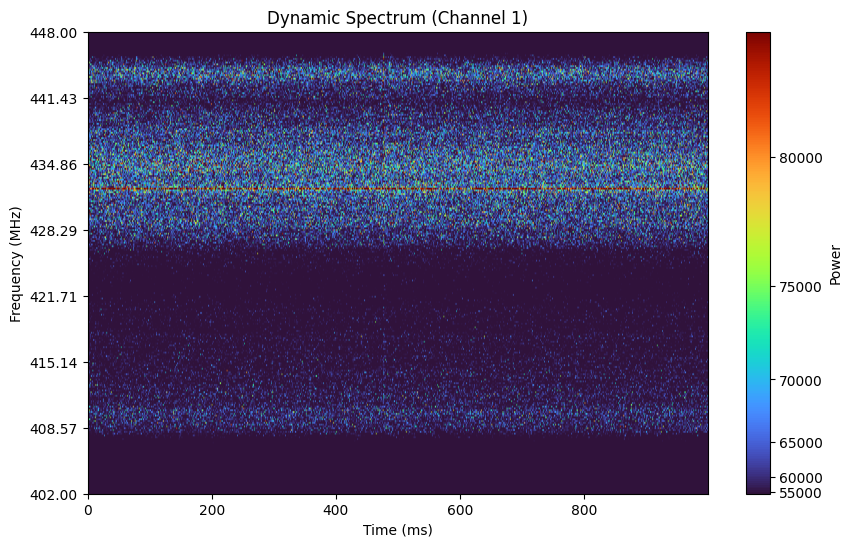

In [9]:
pulsar.RFI_mitigation()
plot_intensity_matrix(pulsar,channel = 0)
plot_intensity_matrix(pulsar,channel = 1)

In [10]:
def fold_matrix(matrix, period_ms, block_size, avg_blocks , sample_rate):
    
    t_bin =  avg_blocks * block_size / sample_rate * 1000 # in mili Sec
    delay_bins = int(period_ms / t_bin)
    print(delay_bins)

    n_time, n_freq = matrix.shape
    print(matrix.shape)

    reshaped = np.zeros(( delay_bins,n_freq))  # Initialize reshaped with a dummy value
    print(reshaped.shape)
    
    i = 0
    while i < n_time / delay_bins - 1 :
        reshaped = reshaped + matrix[int(i*delay_bins):int((i+1)*delay_bins) , :]  # Reshape the matrix
        i += 1
    return reshaped / i

In [11]:
pulsar.pulseperiod_ms = 33.0
pulsar.Manual_dedisperse_pop(channel="all",DM = -56.778)


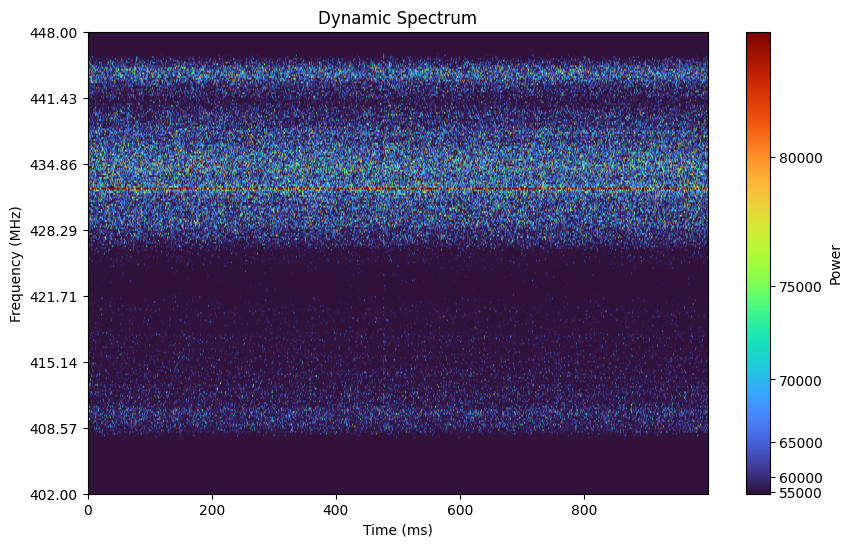

35
(1074, 257)
(35, 257)


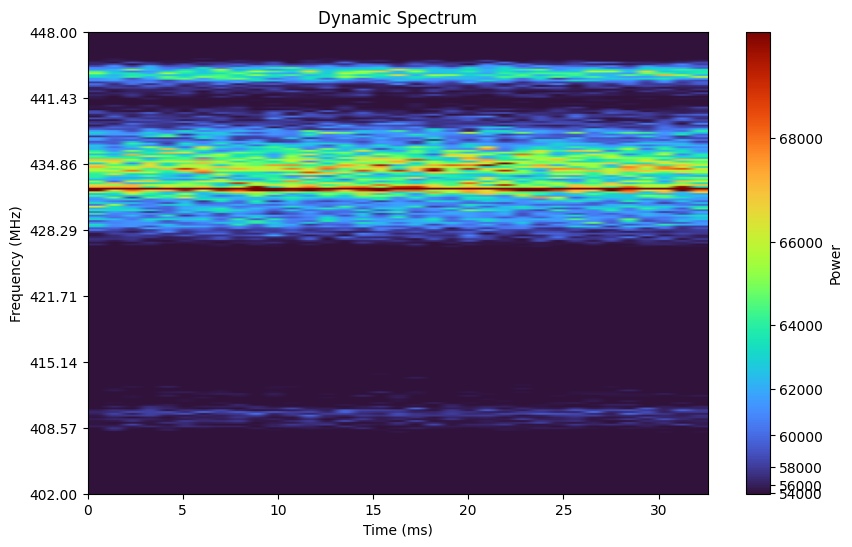

In [12]:
matrix = pulsar.intensity_matrix_ch_s[1]
block_size, avg_blocks , sample_rate = pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate

plot_intensity_matrix_single(matrix, block_size, avg_blocks, sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)
pulsar.pulseperiod_ms = 33.0
folded = fold_matrix(matrix, pulsar.pulseperiod_ms, block_size, avg_blocks , sample_rate)
plot_intensity_matrix_single(folded, block_size, avg_blocks, sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)

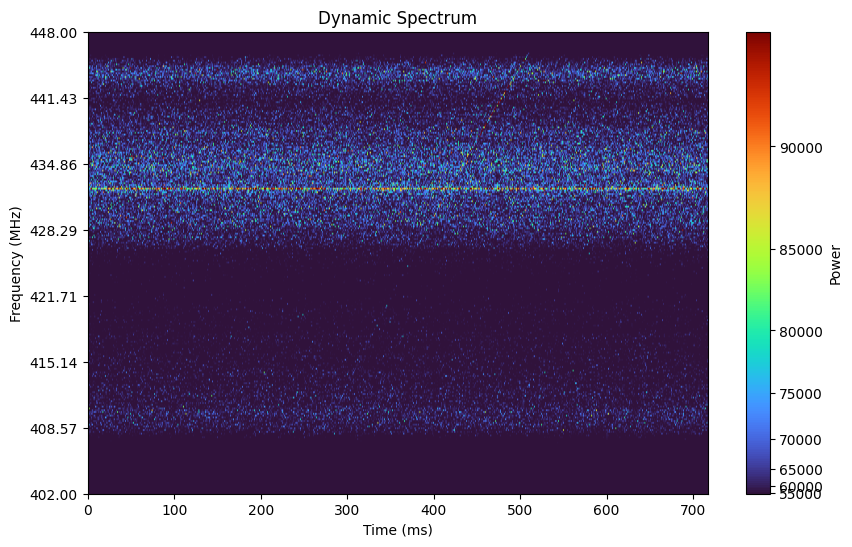

35
(770, 257)
(35, 257)


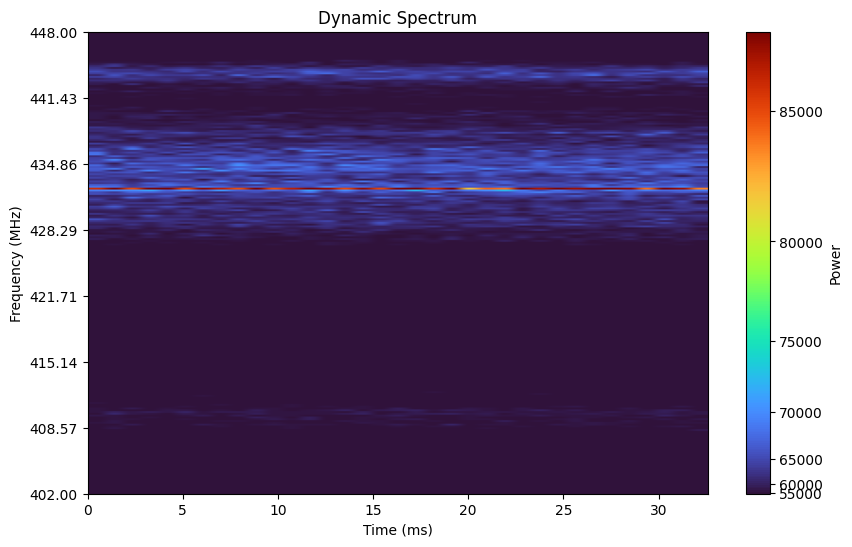

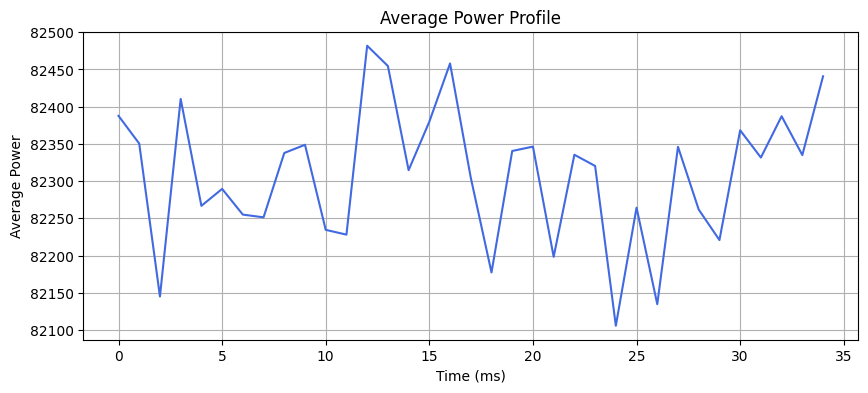

In [13]:
pulsar.compute_intensity_matrix()
pulsar.intensity_matrix_ch_s[1] = np.flip(pulsar.intensity_matrix_ch_s[1],axis=0)  # Reverse the order of the second channel
pulsar.Manual_dedisperse_pop(channel="all",DM = 56.778)

matrix = pulsar.dedispersed_choped_ch_s[1]
block_size, avg_blocks , sample_rate = pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate

plot_intensity_matrix_single(matrix, block_size, avg_blocks, sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)
pulsar.pulseperiod_ms = 33.0
folded = fold_matrix(matrix, pulsar.pulseperiod_ms, block_size, avg_blocks , sample_rate)
power_profile = True  # Set to True to plot the power profile
plot_intensity_matrix_single(folded, block_size, avg_blocks, sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5,power_profile=power_profile)

In [14]:
import numpy as np

# To distinguish a pulsar signal from Gaussian noise, you can use several statistical and signal processing tests.
# Here are some common approaches:

import matplotlib.pyplot as plt

# 1. Visualize the folded profile: Pulsar signals, when folded at the correct period, show a sharp peak.
#    Gaussian noise will not show a significant peak after folding.

# Fold the time series at the known pulsar period
folded_matrix, folded_mean = fold_data(time_series, period_s, fs)

plt.figure(figsize=(8, 4))
plt.plot(folded_mean, color='navy')
plt.xlabel("Sample within Period")
plt.ylabel("Average Amplitude")
plt.title("Folded Profile")
plt.grid(True)
plt.show()

# 2. Signal-to-noise ratio (SNR) of the folded profile
snr = (np.max(folded_mean) - np.mean(folded_mean)) / np.std(folded_mean)
print(f"Folded profile SNR: {snr:.2f}")

# 3. Histogram of the raw data: Gaussian noise should be normally distributed.
plt.figure(figsize=(6, 4))
plt.hist(time_series, bins=100, alpha=0.7, color='gray')
plt.xlabel("Amplitude")
plt.ylabel("Count")
plt.title("Histogram of Time Series")
plt.grid(True)
plt.show()

# 4. Compare the standard deviation and mean: For pure noise, mean ~ 0 and std is stable.
print(f"Time series mean: {np.mean(time_series):.2f}, std: {np.std(time_series):.2f}")

# 5. Power spectrum: Pulsar signals show a peak at the pulse frequency and its harmonics.
freqs = np.fft.rfftfreq(len(time_series), d=time_bin)
power = np.abs(np.fft.rfft(time_series - np.mean(time_series)))**2

plt.figure(figsize=(10, 4))
plt.plot(freqs, power)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of Time Series")
plt.xlim(0, 100)  # Limit to low frequencies for clarity
plt.grid(True)
plt.show()

# Interpretation:
# - If you see a clear peak in the folded profile and in the power spectrum at the expected pulse frequency,
#   and the SNR is much greater than 1, it is likely a pulsar signal.
# - If the folded profile is flat, the histogram is Gaussian, and the power spectrum shows no peaks,
#   the data is likely just noise.

NameError: name 'fold_data' is not defined

In [ ]:
import numpy as np

# Correct time bin calculation
time_bin = (pulsar.block_size * pulsar.avg_blocks) / pulsar.sample_rate

def channel_efficiency(matrix):
    """
    Compute efficiency for each frequency channel in the dynamic spectrum.

    Efficiency E = mean / (std * sqrt(TBP)) where TBP = number of time bins

    Args:
        matrix (2D numpy array): [time, frequency] intensity matrix

    Returns:
        1D numpy array of efficiencies for each frequency channel
    """
    n_time, n_freq = matrix.shape
    means = matrix.mean(axis=0)
    stds = matrix.std(axis=0)
    stds = np.where(stds == 0, 1, stds)  # Avoid division by zero

    # TBP should be the number of time bins
    TBP = n_time
    efficiencies = means / (stds * np.sqrt(TBP))
    return efficiencies

def remove_rfi_by_efficiency(matrix, low_threshold=None, high_threshold=None, fill_value=0, verbose=True):
    """
    Mask or replace RFI-affected frequency channels using efficiency threshold.

    Args:
        matrix (2D array): [time, frequency] intensity matrix
        low_threshold (float): Lower efficiency cutoff threshold. If None, auto-computed as mean - 3*std
        high_threshold (float): Upper efficiency cutoff threshold. If None, auto-computed as mean + 3*std
        fill_value: Value to replace RFI-affected channels with (e.g., np.nan or 0)
        verbose (bool): Whether to print removed channels info

    Returns:
        Cleaned 2D matrix
    """
    efficiency = channel_efficiency(matrix)
    
    # Auto-compute thresholds based on efficiency statistics if not provided
    if low_threshold is None or high_threshold is None:
        eff_mean = np.mean(efficiency)
        eff_std = np.std(efficiency)
        
        if low_threshold is None:
            low_threshold = eff_mean - 3 * eff_std
        if high_threshold is None:
            high_threshold = eff_mean + 3 * eff_std
    
    # Identify bad channels (outliers in efficiency)
    bad_channels_low = efficiency < low_threshold
    bad_channels_high = efficiency > high_threshold
    bad_channels = np.logical_or(bad_channels_low, bad_channels_high)

    cleaned = matrix.copy()
    cleaned[:, bad_channels] = fill_value

    if verbose:
        print(f"Efficiency statistics: mean={np.mean(efficiency):.4f}, std={np.std(efficiency):.4f}")
        print(f"Thresholds: low={low_threshold:.4f}, high={high_threshold:.4f}")
        print(f"Removed {np.sum(bad_channels)} RFI channels out of {matrix.shape[1]} total channels")
        print(f"Bad channels (low efficiency): {np.sum(bad_channels_low)}")
        print(f"Bad channels (high efficiency): {np.sum(bad_channels_high)}")
    
    return cleaned


In [ ]:
# Remove all user-defined variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
# Set path to the parent directory

import os
import psutil
import gc
import numpy as np  # For simulating memory usage

def memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss  # in bytes
    return mem / (1024 * 1024)       # convert to MB

print(f"🔍 Memory before allocation: {memory_usage():.2f} MB")
gc.collect()  # Run garbage collector to free up memory
print(f"🔍 Memory before allocation: {memory_usage():.2f} MB")
